# Introduction

## Définition

statsmodels est un module Python qui **fournit des classes et des fonctions pour l'estimation de nombreux modèles statistiques différents**.

Il permet également de réaliser des tests statistiques et d'explorer des données statistiques.
Une liste complète de statistiques de résultats est disponible pour chaque estimateur.

Nous allons travailler sur une étude de cas très simple afin de permettre à tous les programmeurs, peu importe leur niveau, de démarrer rapidement avec statsmodels.

À partir de données brutes, nous montrerons les étapes nécessaires pour estimer un modèle statistique et pour dessiner un tracé de diagnostic. 

Nous aurons besoin des fonctions fournies par statsmodels, ainsi que pandas (pour analyser et manipuler les données) et patsy (pour décrire les modèles statistiques et construire des matrices de conception).

## Étude de cas

### Chargement des modules et données

Nous allons commencer par charger les modules. Nous avons expliquer dans le dernier paragraphe à quoi servait les packages.

In [2]:
import statsmodels.api as sm

import pandas

import patsy

Nous chargeons à présent un jeu de données "Guerry". Pour la petite histoire, il s'agit d'une collection de données historiques utilisées à l’appui de l’essai de 1833 d’André-Michel Guerry sur les statistiques morales de la France. 

On nomme ce jeu de données "df" pour dataframe:

In [3]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data

Explications des variables:

* sm : réfère à statsmodels
* datasets.get_rdataset : permet de télécharger et retourner le jeu de données
* .data : correspond à ce qu'on souhaite en sortie

Nous sélectionnons les variables d'intérêt que nous stockons dans "vars":

In [4]:
vars = ['Department', 'Lottery', 'Literacy', 'Wealth', 'Region']

On affecte à df ces colonnes afin de ne travailler que sur celles-ci:

In [5]:
df = df[vars]

On peut vérifier que cela a bien fonctionné en affichant le dataframe df:

In [9]:
df

,Department,Lottery,Literacy,Wealth,Region
0,Ain,41,37,73,E
1,Aisne,38,51,22,N
2,Allier,66,13,61,C
3,Basses-Alpes,80,46,76,E
4,Hautes-Alpes,79,69,83,E
...,...,...,...,...,...
81,Vienne,40,25,68,W
82,Haute-Vienne,55,13,67,C
83,Vosges,14,62,82,E
84,Yonne,51,47,30,C


On peut également regarder uniquement les 5 lignes du bas. On aurait pu regarder les 5 premières en enlever le petit "-" devant le 5.

In [10]:
df[-5:]

,Department,Lottery,Literacy,Wealth,Region
81,Vienne,40,25,68,W
82,Haute-Vienne,55,13,67,C
83,Vosges,14,62,82,E
84,Yonne,51,47,30,C
85,Corse,83,49,37,NaN


On observe, pour la dernière ligne, qu'il manque une observation dans la colonne "Region": NaN. Nous allons enlever les valeurs non renseignées en utilisant une méthode DataFrame fournie par pandas:

In [6]:
df = df.dropna()

On va maintenant vérifier qu'il n'y a plus de valeurs non renseignées:

In [14]:
df[-5:]

,Department,Lottery,Literacy,Wealth,Region
80,Vendee,68,28,56,W
81,Vienne,40,25,68,W
82,Haute-Vienne,55,13,67,C
83,Vosges,14,62,82,E
84,Yonne,51,47,30,C


### Exemple de modèle

Nous allons maintenant travailler sur un cas concret.

Nous voulons savoir si les taux d'alphabétisation dans les 86 départements français sont associés aux paris par habitant sur la Loterie Royale dans les années 1820.

Nous devons contrôler le niveau de richesse dans chaque département, et nous voulons également inclure une série de variables fictives sur le côté droit de notre équation de régression pour contrôler l'hétérogénéité non observée due aux effets régionaux. 

Le modèle est estimé à l'aide de la régression des moindres carrés ordinaires (MCO).

Pas de panique ! Nous allons procéder étape par étape ;)

#### Matrices de conception (endog et exog)

*Pour rappel, une matrice de conception est une matrice de valeurs de **variables explicatives** d'un ensemble d'objets (ici de "df").*

*Chaque ligne représente un objet individuel, avec les colonnes successives correspondant aux variables et à leurs valeurs spécifiques pour cet objet.*

Pour nous adapter aux modèles couverts par statsmodels, nous allons devoir créer deux matrices de conception.

La première est une matrice de variable(s) endogène(s), c'est-à-dire des vaiables dépendantes, de régression, etc.

La seconde est une matrice de variable(s) exogène(s), c'est-à-dire des variables indépendants, prédictives, etc.

Les estimations des coefficients MCO sont calculées comme d'habitude:

                      𝛽̂=(𝑋′𝑋)−1𝑋′𝑦

On ne s'inquiète pas, le module patsy fournit une fonction pratique pour préparer des matrices de conception à l'aide de formule du type R.

Nous allons donc utiliser la fonction dmatrices de patsy pour créer des matrices de conception:

In [7]:
y, X = patsy.dmatrices('Lottery ~ Literacy + Wealth + Region', data=df, return_type='dataframe')

Les matrices obtenues ressemblent à ceci:

In [8]:
y[:3]

,Lottery
0,41.0
1,38.0
2,66.0


On affiche ci-dessus les 3 premières valeurs d'y

In [20]:
X[:3]

,Intercept,Region[T.E],Region[T.N],Region[T.S],Region[T.W],Literacy,Wealth
0,1.0,1.0,0.0,0.0,0.0,37.0,73.0
1,1.0,0.0,1.0,0.0,0.0,51.0,22.0
2,1.0,0.0,0.0,0.0,0.0,13.0,61.0


On affiche ci-dessus les 3 premières valeurs de x

On peut observer que:
* Cela nous donne une matrice de 3 lignes x 7 colonnes.
* dmatrices a divisé la variable "Region" en plusieurs variables indicatrices.
* dmatrices a ajouté une constance à la matrice des régresseurs exogènes ("Intercept")
* dmatrices a renvoyé des dataframes pandas au lieu de simple tableaux numpy. Cela nous sera utile car les dataframes permettent à statsmodels (donc nous) de transférer des méta-données (des noms de variables par exemple) lors de l'affichage des résultats.

#### Ajustement et résumé du modèle

L'ajustement d'un modèle dans statsmodels implique généralement 3 étapes plutôt faciles:

1. On utilise la classe de modèle pour décrire le modèle;

2. On ajuste le modèle à l'aide d'une méthode de classe;

3. On inspecte les résultats à l'aide d'une méthode de synthèse.

Pour OLS (la régression linéaire), ceci est réalisé par:

In [9]:
#Étape 1:
mod = sm.OLS(y, X)

In [10]:
#Étape 2:
res = mod.fit()

In [11]:
#Étape 3:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.07e-05
Time:                        18:02:04   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

On obtient ci-dessous toutes les statistiques de la régression linéaire.

Pour ne récupérer que les résultats qui nous intéressent, on pourra utiliser l'objet res:

In [26]:
res.params

Intercept      38.651655
Region[T.E]   -15.427785
Region[T.N]   -10.016961
Region[T.S]    -4.548257
Region[T.W]   -10.091276
Literacy       -0.185819
Wealth          0.451475
dtype: float64

In [27]:
res.rsquared

0.3379508691928822

#### Tests de diagnostic et de spécification

Le module statsmodels nous permet également d'effectuer une gamme de diagnostics de régression et de tests de spécification utiles. 

Dans cet exemple, nous allons appliquer le test Rainbow pour la linéarité (l'hypothèse nulle sera que la relation est correctement modélisée comme linéaire).

*Rappel:*

*L'idée de base du test Rainbow est que même si la relation n'est pas linéaire, un bon ajustement linéaire peut être obtenu sur un sous-échantillon au «milieu» des données.*

*L'hypothèse nulle est rejetée chaque fois que l'ajustement global est significativement pire que celui du sous-échantillon.*

*Le test statistic sous H0 suit une distribution F avec p comme degré de liberté.*

In [12]:
sm.stats.linear_rainbow(res)

(0.847233997615691, 0.6997965543621644)

C'est quoi ces chiffres ?!

Pas de panique ! La sortie produite ci-dessous correspond à la statistique F (voir pagraphe du dessus) et à la valeur p.

Le module statsmodels nous permet de tracer des graphiques.

Nous allons nous lancer dans un premier graphique: un graphique de régression partielle pour un ensemble de régresseurs:

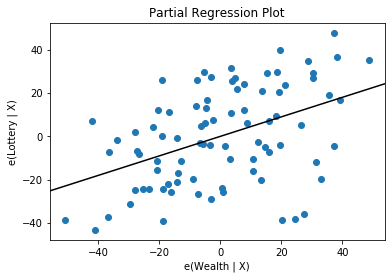

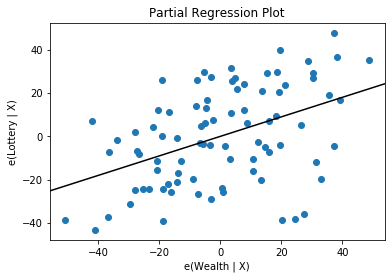

In [16]:
sm.graphics.plot_partregress('Lottery', 'Wealth', ['Region', 'Literacy'],
                             data=df, obs_labels=False)

Explications des variables:

* graphics.plot_partregress : permet de tracer une régression partielle pour un seul régresseur
* data=df : correspond aux données qu'on souhaite utiliser
* obs_labels=False : permet de ne pas avoir le libellé de la valeur sur tous les points du graphique

### Vous êtes enfin prêt à aller plus loin dans vos études et analyses statistiques !

### Documentation

https://www.statsmodels.org/stable/gettingstarted.html